In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
df = pd.read_csv('deathproof_ratings.csv').drop(columns=['Unnamed: 0'])
# Convert JSON strings back to lists
df['Cast'] = df['Cast'].apply(json.loads)
df['Crew'] = df['Crew'].apply(json.loads)
df['Studios'] = df['Studios'].apply(json.loads)
df['Genres'] = df['Genres'].apply(json.loads)
print('Number of movies in the dataset:', df.shape[0], '\n')
df.head()

Number of movies in the dataset: 2401 



,Title,Rating,URL,Duration,Cast,Crew,Studios,Genres
0,Barbie,3.0,https://letterboxd.com/film/barbie,114,"[Margot Robbie, Ryan Gosling, America Ferrera,...",[Greta Gerwig],"[LuckyChap Entertainment, Heyday Films, NB/GG ...","[fantasy, comedy, adventure, Relationship come..."
1,Insidious: The Red Door,2.0,https://letterboxd.com/film/insidious-the-red-...,107,"[Ty Simpkins, Patrick Wilson, Sinclair Daniel,...",[Patrick Wilson],"[Blumhouse Productions, Stage 6 Films, Screen ...","[thriller, horror, mystery, Horror, the undead..."
2,No Hard Feelings,3.0,https://letterboxd.com/film/no-hard-feelings-2023,103,"[Jennifer Lawrence, Andrew Barth Feldman, Laur...",[Gene Stupnitsky],"[Excellent Cadaver, Odenkirk Provissiero Enter...","[comedy, romance, Relationship comedy, Crude h..."
3,Spider-Man: Across the Spider-Verse,4.5,https://letterboxd.com/film/spider-man-across-...,140,"[Shameik Moore, Hailee Steinfeld, Jason Schwar...","[Joaquim Dos Santos, Justin K. Thompson, Kemp ...","[Columbia Pictures, Sony Pictures Animation, L...","[animation, adventure, action, Epic heroes, ac..."
4,Asteroid City,4.0,https://letterboxd.com/film/asteroid-city,105,"[Jason Schwartzman, Scarlett Johansson, Tom Ha...",[Wes Anderson],"[American Empirical Pictures, Indian Paintbrush]","[comedy, drama, Relationship comedy, earth, sc..."


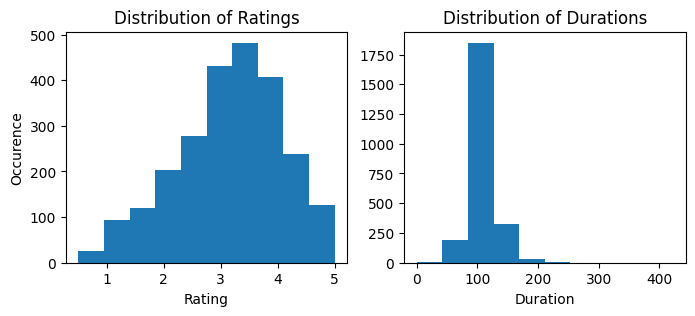

In [3]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
# Plot a histogram of the 'Rating' column in the first subplot
ax[0].hist(df['Rating'])
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Occurence')
ax[0].set_title('Distribution of Ratings')
# Plot a histogram of the 'Duration' column in the second subplot
ax[1].hist(df['Duration'])
ax[1].set_xlabel('Duration')
ax[1].set_title('Distribution of Durations')

plt.show()

# print("Minimum of Ratings:", min(df['Rating']))
# print("Maximum of Ratings:", max(df['Rating']))
# print("Average of Ratings:", round(np.mean(df['Rating']),2))
# print("Variance of Ratings:",round(np.var(df['Rating']),2))

# print("Minimum of Durations:", min(df['Duration']))
# print("Maximum of Durations:", max(df['Duration']))
# print("Average of Durations:", round(np.mean(df['Duration']),2))
# print("Variance of Durations:",round(np.var(df['Duration']),2))

In [4]:
# Calculate the correlation between the 'Rating' and 'Duration' columns in the DataFrame
df[['Rating', 'Duration']].corr()

,Rating,Duration
Rating,1.000000,0.081199
Duration,0.081199,1.000000


Movie durations have no significant correlation with ratings. Thus it will not be used as a feature for the predictior model.

If your data has a high correlation, you might benefit from keeping it.

In [5]:
# Create a list of all unique feature values
def generate_list(df, feature_names): 
    num_features = len(feature_names)
    fig, axs = plt.subplots(1, num_features, figsize=(len(feature_names)*5, 5))  # Create subplots
    
    # To store results for each feature
    result_lists = {}
    
    for idx, feature_name in enumerate(feature_names):
        feature_dict = {}
        
        for index, row in df.iterrows():
            feats = row[feature_name]
            for sub_feat in feats:
                if sub_feat not in feature_dict:
                    feature_dict[sub_feat] = (df['Rating'][index], 1)
                else:
                    feature_dict[sub_feat] = (
                        feature_dict[sub_feat][0] + df['Rating'][index],
                        feature_dict[sub_feat][1] + 1
                    )
        # Calculate average ratings for each feature
        for key in feature_dict: 
            feature_dict[key] = feature_dict[key][0] / feature_dict[key][1]
        # Create and sort a list of tuples (dictionary value, key)
        lst = [(value, key) for key, value in feature_dict.items()] 
        lst = sorted(lst)
        
        feature_list = [element[1] for element in lst]
        ratings_list = [element[0] for element in lst]
        
        var = round(np.var(ratings_list), 3)
        
        result_lists[feature_name] = feature_list
        
        axs[idx].barh(feature_list, ratings_list, align='center')
        axs[idx].invert_yaxis()
        
        axs[idx].set_xlabel('Overall average movie ratings')
        axs[idx].set_ylabel(feature_name)
        axs[idx].set_title(feature_name + ' variance on Rating: ' + str(var))
        axs[idx].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    
    plt.tight_layout()
    plt.show()
    
    return result_lists  

In [6]:
categories = ['Genres', 'Crew', 'Cast', 'Studios']

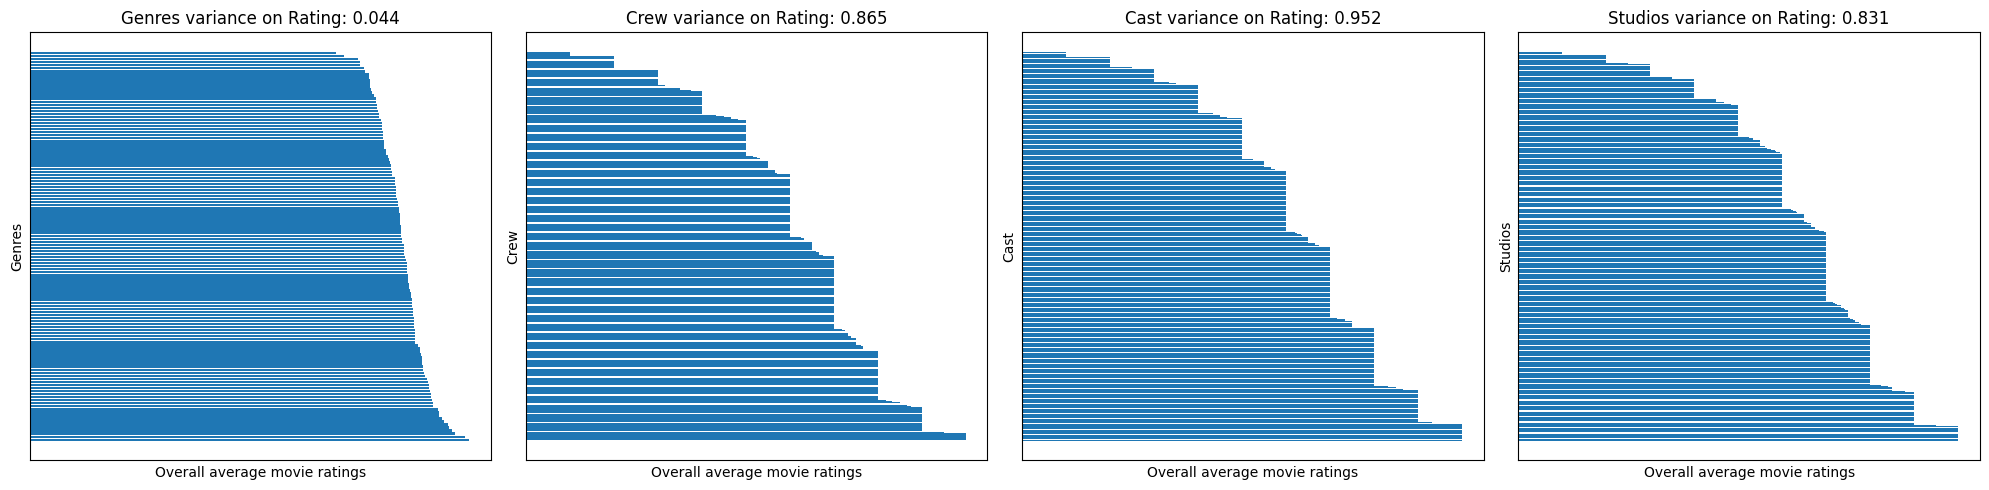

In [7]:
result_lists = generate_list(df, categories)

Genres has the lowest variance and doesn't seem to have a positive impact on model for this user right now. However, after the preprocessing steps, Genres had a high correlation with Rating. Thus, I kept it.

Depending on the user, you might want to consider removing it.

In [8]:
genres_list = result_lists['Genres']
crew_list = result_lists['Crew']
cast_list = result_lists['Cast']
studio_list = result_lists['Studios']

In [9]:
def calculate_bin_array(this_list, all_features):
    """
    Calculate a binary array based on the presence of elements from this_list in all_features.

    Parameters:
    - this_list: List of elements to check for presence
    - all_features: List of all possible elements

    Returns:
    - Binary array (1 if element is in this_list, 0 otherwise)
    """
    binary_array = [1 if element in this_list else 0 for element in all_features]

    return binary_array

In [10]:
df_bin_array = df.copy()
df_bin_array['Cast'] = df['Cast'].apply(lambda x: calculate_bin_array(x, cast_list))
df_bin_array['Crew'] = df['Crew'].apply(lambda x: calculate_bin_array(x, crew_list))
df_bin_array['Studios'] = df['Studios'].apply(lambda x: calculate_bin_array(x, studio_list))
df_bin_array['Genres'] = df['Genres'].apply(lambda x: calculate_bin_array(x, genres_list))

In [11]:
df_bin_array.tail(2)

,Title,Rating,URL,Duration,Cast,Crew,Studios,Genres
2399,The Kid,3.0,https://letterboxd.com/film/the-kid,68,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, ..."
2400,The Cabinet of Dr. Caligari,4.0,https://letterboxd.com/film/the-cabinet-of-dr-...,78,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [12]:
def plot_bin(df, categories):
    """
    Plot a scatter plot for binary values in the DataFrame for each category.

    Parameters:
    - df: DataFrame containing binary values for each category
    - categories: List of categories to plot

    Returns:
    - None (plots the scatter plots)
    """
    # Define font properties for the title
    font = {'family': 'serif', 'color': 'red', 'weight': 'normal', 'size': 10}

    # Create subplots based on the number of categories
    fig, ax = plt.subplots(len(categories), 1, figsize=(5, 2))
    
    # Adjust vertical space between subplots
    plt.subplots_adjust(hspace=5)

    # Iterate through each category
    for idx, category in enumerate(categories):
        # Extract binary values for the current category
        bin_values = df[category]
        
        # Find the indices where the binary value is 1
        bin_index = [i for i, value in enumerate(bin_values) if value == 1]

        # Plot a scatter plot with zeros on the y-axis (only marks the presence of 1)
        ax[idx].scatter(bin_index, np.zeros_like(bin_index))
        
        # Set the title of the subplot
        ax[idx].set_title(category, loc='left', fontdict=font)
        
        # Set the x-axis limit to cover the entire range of binary values
        ax[idx].set_xlim(0, len(bin_values))
        
        # Remove y-axis ticks and labels for better visualization
        ax[idx].set_yticks([])
        
        # Remove x-axis ticks for better visualization
        ax[idx].set_xticks([])

    # Display the plots
    plt.show()


Movie:Spider-Man: Across the Spider-Verse
Rating: 4.5



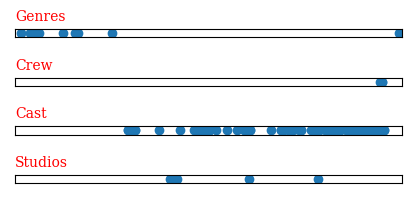

In [13]:
idx = 3
print('Movie:' + df_bin_array.iloc[idx].Title + '\nRating: ' + str(df_bin_array.iloc[idx].Rating) + '\n')
plot_bin(df_bin_array.iloc[idx], categories)

Movie:Plan B
Rating: 3.0



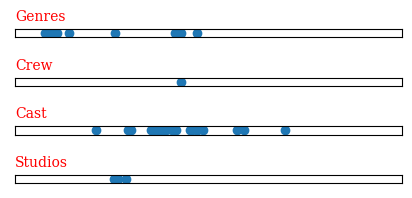

In [14]:
idx = 145
print('Movie:' + df_bin_array.iloc[idx].Title + '\nRating: ' + str(df_bin_array.iloc[idx].Rating) + '\n')
plot_bin(df_bin_array.iloc[idx], categories)

In [15]:
df_bin_array = df_bin_array[['Title', 'Rating', 'URL', 'Cast', 'Crew', 'Studios', 'Genres']]
df_bin_array.tail(2)

,Title,Rating,URL,Cast,Crew,Studios,Genres
2399,The Kid,3.0,https://letterboxd.com/film/the-kid,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, ..."
2400,The Cabinet of Dr. Caligari,4.0,https://letterboxd.com/film/the-cabinet-of-dr-...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [16]:
print(categories)
[len(df_bin_array.iloc[0][cat]) for cat in categories]

['Genres', 'Crew', 'Cast', 'Studios']


[128, 1514, 63126, 3432]

In [17]:
def split_arr(arr, n_splits):
    """
    Split an array into batches of size n_splits.

    Parameters:
    - arr: The input array to be split
    - n_splits: Number of elements in each batch

    Yields:
    - Generator that produces batches of size n_splits
    """
    for i in range(0, len(arr), n_splits):
        yield arr[i:i + n_splits]

def find_concentration(arr, n=3):
    """
    Find concentration points in an array.

    Parameters:
    - arr: The input array
    - n: Number of concentration points to find

    Returns:
    - List of tuples representing concentration points and the number of ones in each batch
    """
    # Separate array into batches
    batches = list(split_arr(arr, int(len(arr) / n)))
    concentrations = []

    # Iterate through batches
    for i in range(len(batches)):
        point = 0
        num_ones = 0

        # Iterate through elements in each batch
        for j in range(len(batches[i])):
            if batches[i][j] == 1:
                point += j + (i * int(len(arr) / n))  # Adding correction for batches
                num_ones += 1

        # Calculate concentration point for the batch
        if num_ones > 0:
            point = point / num_ones
            concentrations.append((point, num_ones))

    return concentrations

def to_concentrations(df, feature_names):
    """
    Apply find_concentration function to specified features in a DataFrame.

    Parameters:
    - df: The DataFrame containing the features
    - feature_names: List of feature names to process

    Returns:
    - DataFrame with concentration points for specified features
    """
    for feature_name in feature_names:
        # Apply find_concentration function to each element in the specified feature
        df[feature_name] = df[feature_name].apply(lambda x: find_concentration(x))
    
    return df


In [18]:
df_bin_array.head()

,Title,Rating,URL,Cast,Crew,Studios,Genres
0,Barbie,3.0,https://letterboxd.com/film/barbie,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, ..."
1,Insidious: The Red Door,2.0,https://letterboxd.com/film/insidious-the-red-...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,No Hard Feelings,3.0,https://letterboxd.com/film/no-hard-feelings-2023,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, ..."
3,Spider-Man: Across the Spider-Verse,4.5,https://letterboxd.com/film/spider-man-across-...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,Asteroid City,4.0,https://letterboxd.com/film/asteroid-city,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [19]:
movies_shortened = to_concentrations(df_bin_array, ['Cast', 'Crew', 'Studios', 'Genres'])

In [20]:
movies_shortened.sample(2)

,Title,Rating,URL,Cast,Crew,Studios,Genres
837,Going Clear: Scientology and the Prison of Belief,3.5,https://letterboxd.com/film/going-clear-scient...,"[(13028.5, 4), (35426.73684210526, 19), (43111...","[(796.0, 1)]","[(1897.3333333333333, 3)]","[(79.0, 1), (100.85714285714286, 7)]"
218,Her Socialist Smile,2.5,https://letterboxd.com/film/her-socialist-smile,"[(13736.0, 2)]","[(337.0, 1)]","[(2307.0, 1)]","[(30.0, 1), (118.0, 1)]"


In [21]:
def w_avg(arr):
    """
    Calculate the weighted average of a list of tuples.

    Parameters:
    - arr: List of tuples where each tuple contains a value and its weight

    Returns:
    - Weighted average
    """
    total_weight = sum(element[1] for element in arr)
    weighted_sum = sum(element[0] * element[1] for element in arr)
    
    return weighted_sum / total_weight if total_weight != 0 else 0


def to_weighted_avg(df, feature_names):
    """
    Apply weighted average calculation to specified features in a DataFrame.

    Parameters:
    - df: The DataFrame containing the features
    - feature_names: List of feature names to process

    Returns:
    - DataFrame with weighted averages for specified features
    """
    # Apply the w_avg function to each element in the specified features
    df[feature_names] = df[feature_names].applymap(w_avg)
    
    return df


In [22]:
w_avg([(1,3), (8,5), (14,2)])

7.1

In [23]:
movies_shortened = to_weighted_avg(movies_shortened, ['Cast', 'Crew', 'Studios', 'Genres'])  # Returns the weighted average index of the feature

In [24]:
movies_shortened.sample(2)

,Title,Rating,URL,Cast,Crew,Studios,Genres
2286,Grey Gardens,3.0,https://letterboxd.com/film/grey-gardens,22621.333333,552.0,1185.0,88.777778
449,The Favourite,5.0,https://letterboxd.com/film/the-favourite,55388.129032,1477.0,2492.8,62.444444


In [25]:
movies_shortened.corr(numeric_only=True)[['Rating']]

,Rating
Rating,1.000000
Cast,0.943284
Crew,0.765538
Studios,0.734926
Genres,0.264910


Correlation of Genres increased due to preprocessing steps

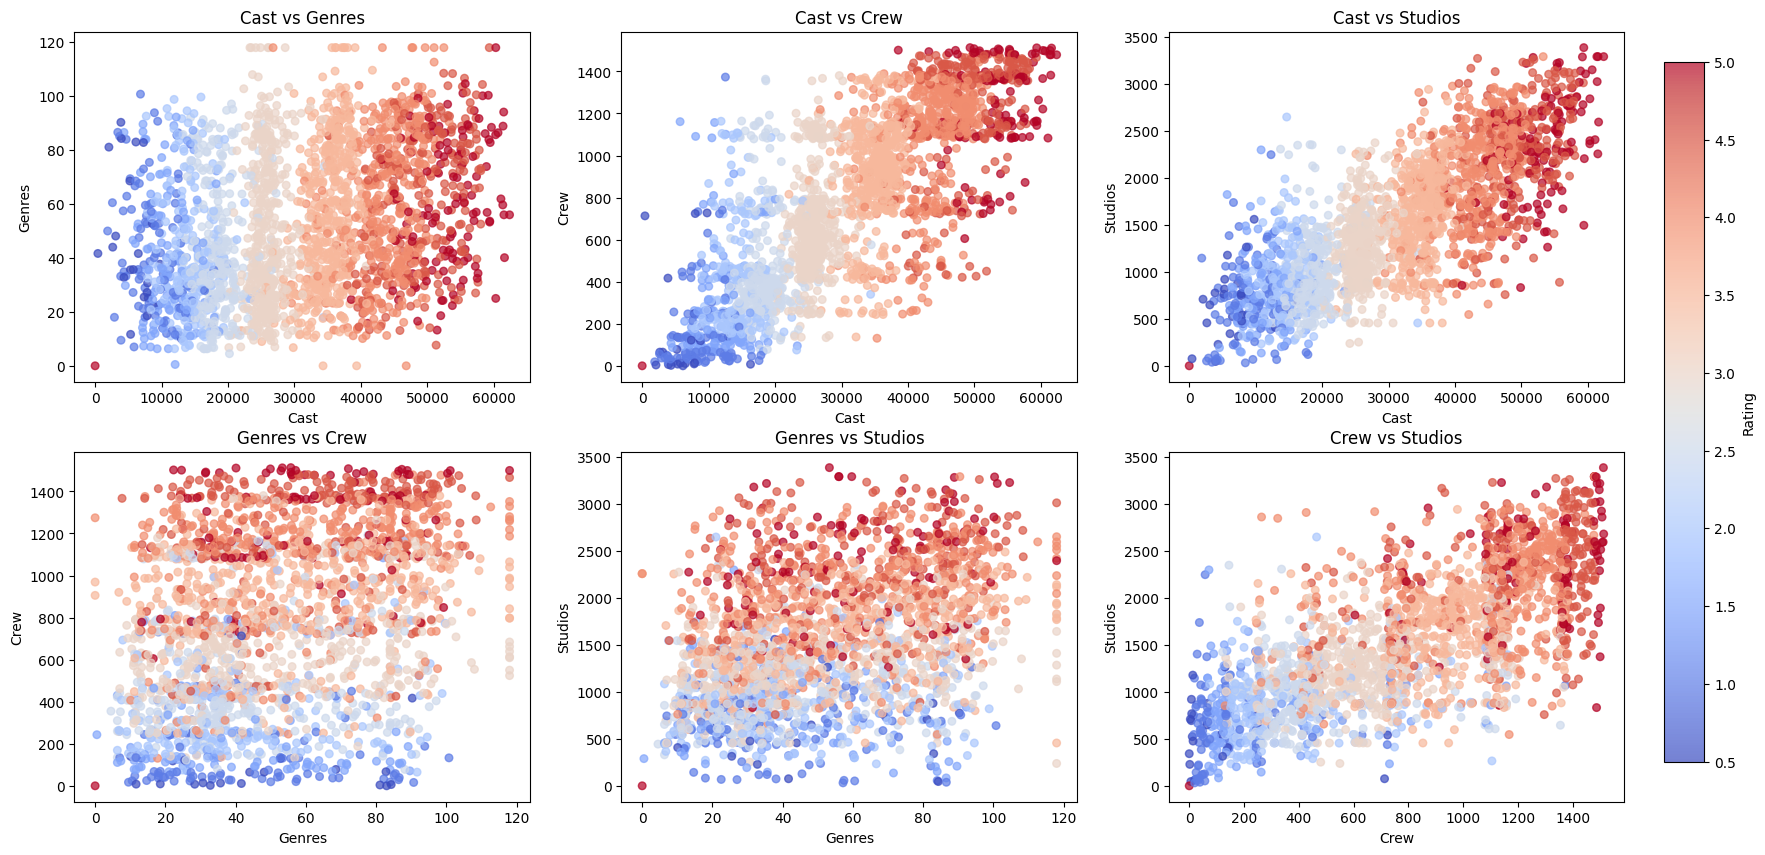

In [26]:
# List of column combinations for x and y axes
column_combinations = [('Cast', 'Genres'), ('Cast', 'Crew'), ('Cast', 'Studios'), ('Genres', 'Crew'),
                       ('Genres', 'Studios'), ('Crew', 'Studios')]

# Creating a 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Creating scatterplots for each combination
for i, (x_col, y_col) in enumerate(column_combinations):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    scatter = ax.scatter(movies_shortened[x_col], movies_shortened[y_col], c=movies_shortened["Rating"], cmap="coolwarm", s=30, alpha=0.7)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f"{x_col} vs {y_col}")
    
# Adding a single colorbar on the right edge
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
plt.colorbar(scatter, cax=cax, label="Rating")
plt.show()

In [27]:
feat_df = movies_shortened[['Cast', 'Crew', 'Studios', 'Genres']]

In [28]:
feat_df.head(2)

,Cast,Crew,Studios,Genres
0,23884.946429,780.0,1320.25,18.272727
1,16660.484848,212.0,1318.60,33.333333


In [29]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Convert the feature DataFrame (feat_df) to float and scale the values between 0 and 1
feat_scaled = pd.DataFrame(scaler.fit_transform(feat_df.astype(float)))

# Set the index and columns of the scaled DataFrame to match the original feat_df
feat_scaled.index = feat_df.index
feat_scaled.columns = feat_df.columns

# Create a separate DataFrame for the target variable ('Rating')
target_df = pd.DataFrame()
target_df['Rating'] = movies_shortened['Rating']


In [30]:
feat_scaled.head(2)

,Cast,Crew,Studios,Genres
0,0.382968,0.515532,0.389723,0.154854
1,0.267132,0.140119,0.389235,0.282486


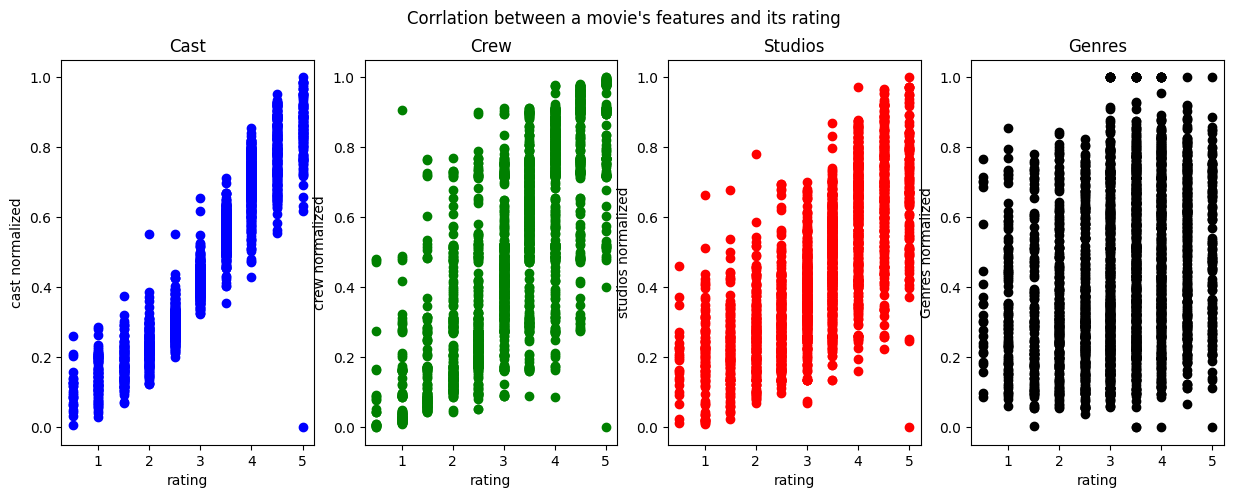

In [31]:
fig, ax = plt.subplots(1,4, figsize=(15,5))

ax[0].scatter(target_df['Rating'], feat_scaled['Cast'], facecolor='blue')
ax[0].set_xlabel('rating')
ax[0].set_ylabel('cast normalized')
ax[0].set_title('Cast')

ax[1].scatter(target_df['Rating'], feat_scaled['Crew'], facecolor='green')
ax[1].set_xlabel('rating')
ax[1].set_ylabel('crew normalized')
ax[1].set_title('Crew')

ax[2].scatter(target_df['Rating'], feat_scaled['Studios'], facecolor='red')
ax[2].set_xlabel('rating')
ax[2].set_ylabel('studios normalized')
ax[2].set_title('Studios')

ax[3].scatter(target_df['Rating'], feat_scaled['Genres'], facecolor='black')
ax[3].set_xlabel('rating')
ax[3].set_ylabel('Genres normalized')
ax[3].set_title('Genres')

fig.suptitle("Corrlation between a movie's features and its rating")
plt.show()

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feat_scaled, target_df, test_size=0.2)

In [33]:
X_train.head(2)

,Cast,Crew,Studios,Genres
1168,0.698547,0.739590,0.718371,0.651695
967,0.630759,0.720423,0.663288,0.605085


In [34]:
y_train.head(2)

,Rating
1168,4.0
967,3.5


In [35]:
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [36]:
rfr = RandomForestRegressor()
rfr.fit(X_train.values, y_train.values.ravel())

RandomForestRegressor()

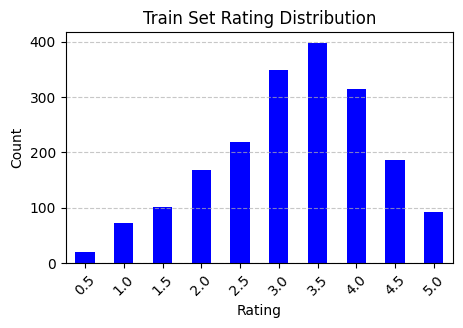

In [37]:
value_counts = y_train.Rating.value_counts().sort_index()

plt.figure(figsize=(5, 3))
value_counts.plot(kind='bar', color='blue')

plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Train Set Rating Distribution')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [38]:
y_pred = rfr.predict(X_test.values)

In [39]:
from sklearn.metrics import r2_score,  mean_squared_error

r2score = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R^2 Score for predictions: {r2score:.3f}")
print(f"MSE for predictions: {mse:.3f}")

R^2 Score for predictions: 0.920
MSE for predictions: 0.087


In [40]:
bay_rid = BayesianRidge()
bay_rid.fit(X_train.values, y_train.values.ravel())
lin_reg = LinearRegression()
lin_reg.fit(X_train.values, y_train.values.ravel())
rfr = RandomForestRegressor()
rfr.fit(X_train.values, y_train.values.ravel())

for model in [bay_rid, lin_reg, rfr]:
    y_pred = model.predict(X_test.values)
    r2score = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Model:{model}, R2 Score:{r2score:.3f}, MSE:{mse:.3f}')

Model:BayesianRidge(), R2 Score:0.891, MSE:0.119
Model:LinearRegression(), R2 Score:0.891, MSE:0.119
Model:RandomForestRegressor(), R2 Score:0.921, MSE:0.086


In [57]:
import requests
from bs4 import BeautifulSoup
import time

def get_movie_features(urls):
    # Define indices for each tab in the HTML structure
    tab_indices = {
        0: [0],  # only cast box
        1: [0],  # only director crew
        2: [0],  # only studios
        3: [0]   # only genres
    }

    # List to store data for all movies
    all_movie_data = []

    # Loop through each URL provided
    for url in urls:
        # Send a GET request to the URL and parse the HTML content
        data = requests.get(url)
        soup = BeautifulSoup(data.text, 'html.parser')
        
        # Dictionary to store data for the current movie
        df_data = {}
        
        # Extract the movie title from the HTML
        df_data['Title'] = soup.select('h1.headline-1')[0].text
        
        # Loop through each tab and specified indices
        for tab, indices in tab_indices.items():
            try:
                df_data[tab] = []
                # Extract data from the specified indices within the tab
                for index in indices:
                    for group in soup.select('div.tabbed-content-block')[tab].select('div.text-sluglist')[index].find_all('a'):
                        for g in group:
                            df_data[tab].append(g.text)
            except:
                continue

        # Mapping between the original keys and desired keys
        key_mapping = {
            0: "Cast",
            1: "Crew",
            2: 'Studios',
            3: 'Genres'
        }

        # Create a new dictionary with renamed keys
        new_dict = {key_mapping.get(key, key): value for key, value in df_data.items()}
        new_dict['URL'] = url
        all_movie_data.append(new_dict)
        # Delaying process to avoid errors resulted from excessive request to the website
        print('Waiting 3 seconds before request...') 
        time.sleep(3)
        

    # Create a DataFrame from the collected movie data
    df = pd.DataFrame(all_movie_data)
    return df


In [55]:
import warnings

# Ignore all warnings within this cell
warnings.filterwarnings("ignore")

def predict_new_movie(url, reg, df_bin_array=df_bin_array,df=df):
    new_row = get_movie_features([url])#.drop(['Genres'], axis=1) # If you didn't use Genres column for model training.
    if new_row['Title'][0] in df.Title.values:
        print('Previous rating is:',  df[df.Title == new_row['Title'][0]]['Rating'].values[0])
    # Add the new row (here df_bin_array is just an instance in the function. It wont affect the original df_bin_array_variable)
    df_bin_array = df_bin_array.append(new_row, ignore_index=True)
    df = df.append(new_row, ignore_index=True)

    for col, lst in {'Cast':cast_list, 'Crew':crew_list, 'Studios':studio_list, 'Genres':genres_list}.items():
        iterate_all = False
        for el in df_bin_array.iloc[-1][col]:
            if el not in lst:
                iterate_all = True
                lst.append(el)
        if iterate_all:
            df_bin_array[col] = df[col].copy()
            df_bin_array[col] = df[col].apply(lambda x: calculate_bin_array(x, lst))
        else:
            df_bin_array.at[df_bin_array.shape[0]-1, col] = df_bin_array.iloc[-1:][col].apply(lambda x: calculate_bin_array(x, lst)).copy().values[0]

    if iterate_all:
        movies_shortened = to_concentrations(df_bin_array, ['Cast', 'Crew', 'Studios', 'Genres'])
        movies_shortened = to_weighted_avg(movies_shortened, ['Cast', 'Crew', 'Studios', 'Genres'])
    else:
        movies_shortened = to_concentrations(df_bin_array.iloc[-1:], ['Cast', 'Crew', 'Studios', 'Genres'])
        movies_shortened = to_weighted_avg(movies_shortened.iloc[-1:], ['Cast', 'Crew', 'Studios', 'Genres'])

    feat_df = movies_shortened[['Cast', 'Crew', 'Studios', 'Genres']]

    scaled_new_row = scaler.transform([feat_df.iloc[-1]])
    # Create a DataFrame for the scaled new row
    scaled_new_df = pd.DataFrame(scaled_new_row, columns=feat_df.columns)
    pred_score = reg.predict(scaled_new_df.values)
    print(f'Predicted Score for {df.iloc[-1].Title} is: {pred_score}')

Showing the predicted ratings for movies in the test set.

(These movies have been rated by the user but the model has no information about these movies since they are seperated from the train set.)

In [56]:
for i in range(10):
    predict_new_movie(df[df.index == y_test.index[i]].URL.values[0], rfr)
    print('\n')

Waiting 2 seconds for new request...
Previous rating is: 1.0
Predicted Score for I Was at Home, But... is: [0.99]


Waiting 2 seconds for new request...
Previous rating is: 3.5
Predicted Score for Fire of Love is: [3.5]


Waiting 2 seconds for new request...
Previous rating is: 3.0
Predicted Score for The Midnight Meat Train is: [3.]


Waiting 2 seconds for new request...
Previous rating is: 2.0
Predicted Score for Fantastic Four is: [2.285]


Waiting 2 seconds for new request...
Previous rating is: 5.0
Predicted Score for Columbus is: [4.45]


Waiting 2 seconds for new request...
Previous rating is: 4.0
Predicted Score for Rafiki is: [4.12]


Waiting 2 seconds for new request...
Previous rating is: 3.0
Predicted Score for Sherlock Holmes is: [2.89]


Waiting 2 seconds for new request...
Previous rating is: 2.5
Predicted Score for Scream 3 is: [3.]


Waiting 2 seconds for new request...
Previous rating is: 1.0


TypeError: object of type 'float' has no len()

In [ ]:
predict_new_movie('https://letterboxd.com/film/the-room/', rfr)

In [ ]:
len(crew_list)